<a href="https://colab.research.google.com/github/Deleon57/EDAR-Data/blob/main/KNN222.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


# Get Data

In [2]:
ticker = "GFI.JO"
data = yf.download(ticker, start="2013-01-01", end="2024-12-31")

data.reset_index(inplace=True)
data.head(10)

/tmp/ipython-input-3713280938.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start="2013-01-01", end="2024-12-31")
[*********************100%***********************]  1 of 1 completed


Price,Date,Close,High,Low,Open,Volume
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO
0,2013-01-01,9091.963867,9091.963867,9091.963867,9091.963867,0
1,2013-01-02,9323.319336,9325.947481,9043.768639,9151.557666,2277190
2,2013-01-03,9335.583008,9376.771228,9183.977665,9289.137525,1638359
3,2013-01-04,9049.027344,9131.402862,8955.259623,9113.876695,2154183
4,2013-01-07,9104.232422,9156.811871,9000.824970,9083.200447,1833898
5,2013-01-08,8928.091797,9148.051381,8900.925854,9013.972140,2221997
6,2013-01-09,9006.960938,9037.632696,8860.613781,9020.982257,2344840
7,2013-01-10,9091.963867,9091.963867,8906.180931,8982.422451,1564839
8,2013-01-11,9201.507812,9240.066932,9112.998347,9113.875045,3899959


# Feature engineer

In [3]:
df = data.copy()

# 1. Spreads
df['High_Low'] = df['High'] - df['Low']
df['Open_Close'] = df['Open'] - df['Close']

# 2. Moving Averages
df['SMA_5'] = df['Close'].rolling(5).mean()
df['SMA_10'] = df['Close'].rolling(10).mean()
df['SMA_20'] = df['Close'].rolling(20).mean()
df['SMA_50'] = df['Close'].rolling(50).mean()
df['SMA_100'] = df['Close'].rolling(100).mean()
df['SMA_200'] = df['Close'].rolling(200).mean()

# 3. Exponential Moving Averages
df['EMA_5'] = df['Close'].ewm(span=5, adjust=False).mean()
df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['Close'].ewm(span=50, adjust=False).mean()

# 4. Rolling Std (Volatility)
df['RollingStd_20'] = df['Close'].rolling(20).std()

# 5. Lag Features (Close & Volume)
for lag in range(1, 6):
    df[f'Close_t-{lag}'] = df['Close'].shift(lag)
    df[f'Volume_t-{lag}'] = df['Volume'].shift(lag)
    df[f'Return_t-{lag}'] = df['Close'].pct_change(lag)

# 6. Relative Strength Index (RSI)
window_length = 14
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=window_length).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=window_length).mean()
rs = gain / loss
df['RSI_14'] = 100 - (100 / (1 + rs))

# 7. On-Balance Volume (OBV)
df['OBV'] = (np.sign(df['Close'].diff()) * df['Volume']).fillna(0).cumsum()

# 8. Moving Average Convergence Divergence (MACD)
df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = df['EMA_12'] - df['EMA_26']
df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

# 9. Bollinger Bands (20-day)
df['BB_Middle'] = df['Close'].rolling(window=20).mean()

# 10. Average True Range (ATR)
df['H-L'] = df['High'] - df['Low']
df['H-C'] = abs(df['High'] - df['Close'].shift())
df['L-C'] = abs(df['Low'] - df['Close'].shift())
df['TR'] = df[['H-L', 'H-C', 'L-C']].max(axis=1)
df['ATR_14'] = df['TR'].rolling(14).mean()

# Drop NA rows
df.dropna(inplace=True)

# Target: 1 if next-day close > today’s close, else 0
df['Target'] = (df['Close'].shift(-1) > df['Close']).astype(int)

df.dropna(inplace=True)
df.head(10)

Price,Date,Close,High,Low,Open,Volume,High_Low,Open_Close,SMA_5,SMA_10,...,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14,Target
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,...,,,,,,,,,,
199,2013-10-07,4485.154297,4575.934778,4452.233903,4479.168771,1173121,123.700875,-5.985526,4500.716309,4591.396973,...,4838.440364,-222.953666,-231.006154,4695.545093,123.700875,80.805383,42.895492,123.700875,162.749189,0
200,2013-10-08,4451.235352,4556.979625,4449.240177,4556.979625,1274177,107.739448,105.744273,4497.124902,4562.067773,...,4809.758511,-219.541251,-228.713173,4660.230493,107.739448,71.825328,35.914120,107.739448,163.533007,0
201,2013-10-09,4380.407227,4470.190112,4355.467536,4464.204586,1392042,114.722576,83.797360,4467.995313,4531.242334,...,4777.954712,-220.015919,-226.973722,4627.858789,114.722576,18.954761,95.767815,114.722576,146.859105,1
202,2013-10-10,4442.257812,4468.195091,4301.597954,4375.419440,1802995,166.597138,-66.838373,4450.836816,4506.402441,...,4753.088275,-212.946556,-224.168289,4609.902222,166.597138,87.787865,78.809273,166.597138,139.662360,0
203,2013-10-11,4336.512207,4429.287831,4302.594237,4406.343321,1050501,126.693593,69.831114,4419.113379,4471.187500,...,4722.230789,-213.416687,-222.017969,4590.299536,126.693593,12.969982,139.663575,139.663575,134.959538,1
204,2013-10-14,4399.360840,4436.271577,4279.650341,4321.549015,2032833,156.621236,-77.811824,4401.954687,4451.335498,...,4698.314496,-206.339358,-218.882246,4578.079028,156.621236,99.759370,56.861866,156.621236,146.146770,0
205,2013-10-15,4336.512207,4406.343321,4271.669029,4372.425352,2081226,134.674292,35.913145,4379.010059,4438.067480,...,4671.514327,-203.456562,-215.797109,4561.519092,134.674292,6.982482,127.691811,134.674292,143.225202,1
206,2013-10-16,4369.433594,4488.146516,4344.493904,4366.440831,2451447,143.652611,-2.992763,4376.815332,4422.405322,...,4649.137976,-196.253161,-211.888320,4545.557690,143.652611,151.634309,7.981697,151.634309,143.724067,1
207,2013-10-17,4424.300293,4424.300293,4289.625989,4329.529486,7904643,134.674304,-94.770807,4373.223828,4412.030322,...,4632.483333,-183.996136,-206.309883,4521.665479,134.674304,54.866699,79.807605,134.674304,142.940247,1


In [4]:
# --- Export full dataset with all features ---
df.to_csv("GFI_features.csv", index=False)

# If using Google Colab, download the file
from google.colab import files
files.download("GFI_features.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Scaling all the data

In [6]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Feature groups ---
price_cols = [
    'Open','High','Low','Close',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_12','EMA_20','EMA_26','EMA_50','BB_Middle'
]

volume_cols = ['Volume']   # log + scale
obv_cols = ['OBV']         # can be negative, scale only

relative_cols = [
    'High_Low','Open_Close',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'MACD','Signal_Line','ATR_14','H-L','H-C','L-C','TR',
    'RollingStd_20'
]

bounded_cols = ['RSI_14']  # already in 0–100 (but we’ll rescale to 0–1 below)

# --- NEW groups for lag features ---
close_lag_cols = ['Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5']
volume_lag_cols = ['Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5']

# --- Copy full set ---
df_scaled = df.copy()

# 1. Prices & MAs -> MinMax 0–1
price_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[price_cols] = price_scaler.fit_transform(df[price_cols])

# 2. Volume -> log + MinMax 0–1
df_scaled['Volume'] = np.log1p(df['Volume'])
vol_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[['Volume']] = vol_scaler.fit_transform(df_scaled[['Volume']])

# 3. OBV -> MinMax directly 0–1
obv_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[['OBV']] = obv_scaler.fit_transform(df[['OBV']])

# 4. Relative cols -> MinMax 0–1
rel_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[relative_cols] = rel_scaler.fit_transform(df[relative_cols])

# 5. RSI (originally 0–100) -> rescale to 0–1
df_scaled[bounded_cols] = df[bounded_cols] / 100.0

# --- EXTRA FIX for lags ---

# Close lags
close_lag_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[close_lag_cols] = close_lag_scaler.fit_transform(df[close_lag_cols])

# Volume lags
volume_lag_scaler = MinMaxScaler(feature_range=(0,1))
df_scaled[volume_lag_cols] = volume_lag_scaler.fit_transform(df[volume_lag_cols])

# --- Add Target as the last column ---
df_scaled['Target'] = df['Target'].values

# --- Preview ---
print("Scaled dataset sample (0–1):")
display(df_scaled.head())


Scaled dataset sample (0–1):


Price,Date,Close,High,Low,Open,Volume,High_Low,Open_Close,SMA_5,SMA_10,...,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14,Target
Ticker,,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,...,,,,,,,,,,
199,2013-10-07,0.042645,0.045143,0.046604,0.045551,0.820032,0.017075,0.448137,0.042834,0.044905,...,0.048851,0.367023,0.349518,0.047335,0.017075,0.017725,0.010538,0.017075,0.047417,0
200,2013-10-08,0.041606,0.044566,0.046509,0.048019,0.824880,0.014872,0.466499,0.042718,0.043941,...,0.047843,0.367922,0.350182,0.046143,0.014872,0.015755,0.008822,0.014872,0.047878,0
201,2013-10-09,0.039437,0.041924,0.043513,0.045076,0.830072,0.015836,0.462892,0.041780,0.042928,...,0.046724,0.367797,0.350685,0.045051,0.015836,0.004158,0.023526,0.015836,0.038067,1
202,2013-10-10,0.041331,0.041863,0.041793,0.042260,0.845250,0.022996,0.438136,0.041227,0.042112,...,0.045850,0.369660,0.351498,0.044446,0.022996,0.019256,0.019360,0.022996,0.033833,0
203,2013-10-11,0.038092,0.040679,0.041825,0.043241,0.813554,0.017488,0.460597,0.040205,0.040955,...,0.044765,0.369536,0.352120,0.043784,0.017488,0.002845,0.034309,0.019278,0.031066,1


# Preprocessing the data

In [17]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# --- Feature groups ---
price_cols = [
    'Open','High','Low','Close',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_12','EMA_20','EMA_26','EMA_50','BB_Middle'
]

volume_cols = ['Volume']   # only raw volume gets log transform
obv_cols = ['OBV']         # OBV can be negative → no log, just scale

relative_cols = [
    'High_Low','Open_Close',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'MACD','Signal_Line','ATR_14','H-L','H-C','L-C','TR'
]

bounded_cols = ['RSI_14']   # already in 0–100


X_train_scaled = X_train_full.copy()
X_test_scaled = X_test_full.copy()

#. Prices & MAs -> MinMax 0–100 ---
price_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[price_cols] = price_scaler.fit_transform(X_train_full[price_cols])
X_test_scaled[price_cols] = price_scaler.transform(X_test_full[price_cols])

#. Volume -> log + MinMax 0–100 ---
X_train_scaled['Volume'] = np.log1p(X_train_full['Volume'])
X_test_scaled['Volume'] = np.log1p(X_test_full['Volume'])

vol_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[['Volume']] = vol_scaler.fit_transform(X_train_scaled[['Volume']])
X_test_scaled[['Volume']] = vol_scaler.transform(X_test_scaled[['Volume']])

# OBV (can be negative) -> MinMax directly ---
obv_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[['OBV']] = obv_scaler.fit_transform(X_train_full[['OBV']].values.reshape(-1,1))
X_test_scaled[['OBV']] = obv_scaler.transform(X_test_full[['OBV']].values.reshape(-1,1))

# --- 4. Relative cols -> MinMax 0–100 ---
rel_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[relative_cols] = rel_scaler.fit_transform(X_train_full[relative_cols])
X_test_scaled[relative_cols] = rel_scaler.transform(X_test_full[relative_cols])

# --- 5. RSI (already 0–100) left as-is ---
X_train_scaled[bounded_cols] = X_train_full[bounded_cols]
X_test_scaled[bounded_cols] = X_test_full[bounded_cols]

# --- Extra groups ---
close_lag_cols = ['Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5']
volume_lag_cols = ['Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5']
rolling_cols = ['SMA_20']   # you can add others like rolling MAs if needed

# --- Scale Close lags ---
close_lag_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[close_lag_cols] = close_lag_scaler.fit_transform(X_train_full[close_lag_cols])
X_test_scaled[close_lag_cols]  = close_lag_scaler.transform(X_test_full[close_lag_cols])

# --- Scale Volume lags ---
volume_lag_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[volume_lag_cols] = volume_lag_scaler.fit_transform(X_train_full[volume_lag_cols])
X_test_scaled[volume_lag_cols]  = volume_lag_scaler.transform(X_test_full[volume_lag_cols])

# --- Scale SMA_20 separately if needed ---
roll_scaler = MinMaxScaler(feature_range=(0,1))
X_train_scaled[rolling_cols] = roll_scaler.fit_transform(X_train_full[rolling_cols])
X_test_scaled[rolling_cols]  = roll_scaler.transform(X_test_full[rolling_cols])

# --- Preview ---
print("Scaled training data sample:")
display(X_train_scaled.head())


Scaled training data sample:


Price,Open,High,Low,Close,Volume,SMA_5,SMA_10,SMA_20,SMA_50,SMA_100,...,EMA_12,EMA_26,MACD,Signal_Line,BB_Middle,H-L,H-C,L-C,TR,ATR_14
Ticker,GFI.JO,GFI.JO,GFI.JO,GFI.JO,GFI.JO,,,,,,...,,,,,,,,,,
199,0.049972,0.050203,0.052684,0.047677,0.820032,0.047905,0.049967,0.052690,0.068120,0.072701,...,0.048175,0.053305,0.367023,0.349518,0.052690,0.017075,0.017725,0.010538,0.017075,0.047417
200,0.052680,0.049561,0.052576,0.046515,0.824880,0.047776,0.048895,0.051364,0.066987,0.072261,...,0.047232,0.052205,0.367922,0.350182,0.051364,0.014872,0.015755,0.008822,0.014872,0.047878
201,0.049452,0.046623,0.049190,0.044090,0.830072,0.046726,0.047768,0.050149,0.065845,0.071752,...,0.046026,0.050985,0.367797,0.350685,0.050149,0.015836,0.004158,0.023526,0.015836,0.038067
202,0.046362,0.046556,0.047245,0.046208,0.845250,0.046108,0.046859,0.049474,0.064649,0.071244,...,0.045362,0.050031,0.369660,0.351498,0.049474,0.022996,0.019256,0.019360,0.022996,0.033833
203,0.047438,0.045239,0.047281,0.042586,0.813554,0.044965,0.045572,0.048738,0.063613,0.070743,...,0.044192,0.048847,0.369536,0.352120,0.048738,0.017488,0.002845,0.034309,0.019278,0.031066


In [18]:
# --- Export scaled training data ---
X_train_scaled.to_csv("GFI_train_scaled.csv", index=False)

# --- Export scaled testing data ---
X_test_scaled.to_csv("GFI_test_scaled.csv", index=False)

# Download both (Colab)
from google.colab import files
files.download("GFI_train_scaled.csv")
files.download("GFI_test_scaled.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#Train and split data

In [9]:
train = df[df['Date'] < "2024-01-01"]
test = df[df['Date'] >= "2024-01-01"]

feature_pool = [
    'Open', 'High', 'Low', 'Close', 'Volume',
    'SMA_5','SMA_10','SMA_20','SMA_50','SMA_100','SMA_200',
    'EMA_5','EMA_20','EMA_50',
    'RollingStd_20','High_Low','Open_Close',
    'Close_t-1','Close_t-2','Close_t-3','Close_t-4','Close_t-5',
    'Volume_t-1','Volume_t-2','Volume_t-3','Volume_t-4','Volume_t-5',
    'Return_t-1','Return_t-2','Return_t-3','Return_t-4','Return_t-5',
    'RSI_14',
    'OBV','EMA_12','EMA_26','MACD','Signal_Line','BB_Middle',
    'H-L','H-C','L-C','TR','ATR_14'
]
X_train_full = train[feature_pool]
y_train = train['Target']
X_test_full = test[feature_pool]
y_test = test['Target']


# Standardize feature

# Search for best combination of features that will have highest accuracy

In [26]:
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

best_score = 0
best_features = None
best_model = None

random.seed(42)  # reproducibility

for _ in range(300):
    r = random.randint(4, 5)  # choose random number of features
    combo = random.sample(feature_pool, r)  # choose random subset

    # use scaled data
    X_train = X_train_scaled[list(combo)]
    X_test = X_test_scaled[list(combo)]

    # train KNN
    model = KNeighborsClassifier(n_neighbors=5)
    model.fit(X_train, y_train)

    # evaluate
    preds = model.predict(X_test)
    acc = accuracy_score(y_test, preds)

    # track best
    if acc > best_score:
        best_score = acc
        best_features = combo
        best_model = model

print("Best Accuracy:", best_score)
print("Best Feature Set:", best_features)


Best Accuracy: 0.5783132530120482
Best Feature Set: ['L-C', 'EMA_12', 'Open', 'SMA_5']


# Confusion matrix

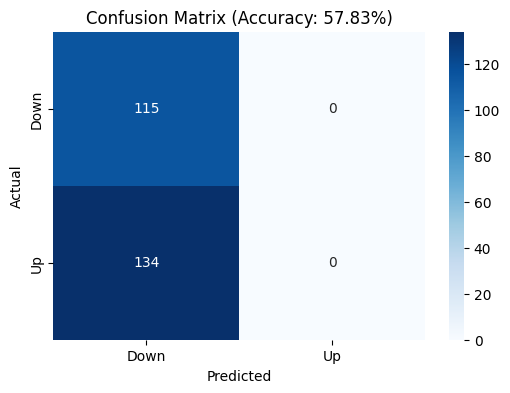

In [27]:
X_test_best = X_test_full[list(best_features)]
y_pred = best_model.predict(X_test_best)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Down","Up"], yticklabels=["Down","Up"])
plt.title(f"Confusion Matrix (Accuracy: {best_score:.2%})")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()


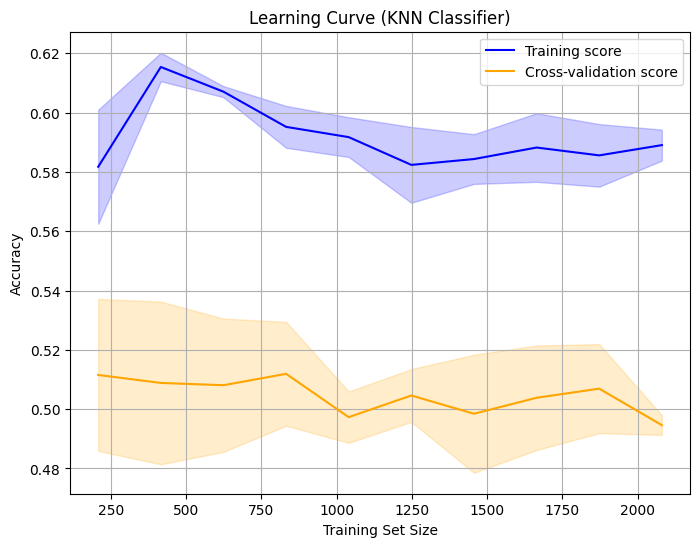

In [24]:
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    best_model,
    X_train_full[list(best_features)],
    y_train,
    cv=5,
    scoring="accuracy",
    n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

plt.figure(figsize=(8,6))
plt.plot(train_sizes, train_mean, label="Training score", color="blue")
plt.plot(train_sizes, test_mean, label="Cross-validation score", color="orange")

plt.fill_between(train_sizes, train_mean-train_std, train_mean+train_std, alpha=0.2, color="blue")
plt.fill_between(train_sizes, test_mean-test_std, test_mean+test_std, alpha=0.2, color="orange")

plt.title("Learning Curve (KNN Classifier)")
plt.xlabel("Training Set Size")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.grid()
plt.show()


# Search for best value of k

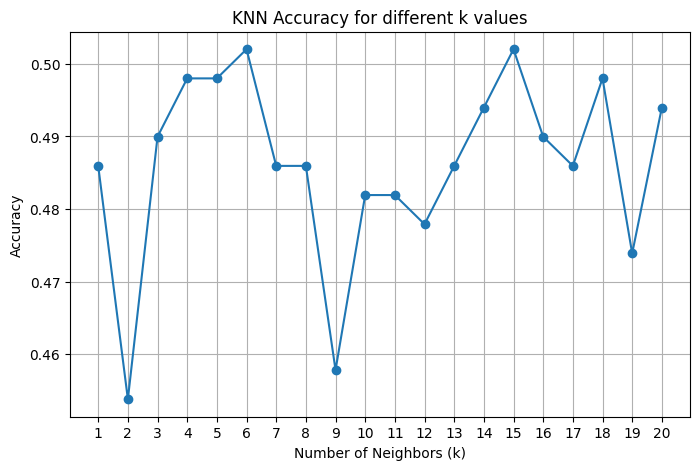

In [25]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

k_values = range(1, 21)
scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scaled, y_train)
    y_pred = knn.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    scores.append(acc)

plt.figure(figsize=(8,5))
plt.plot(k_values, scores, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for different k values')
plt.xticks(k_values)
plt.grid(True)
plt.show()

best_k = k_values[scores.index(max(scores))]
